# CrossBee workflow demo based on Python Script Modules for LBD Text Mining Analysis

CrossBee is a system that recommends bridging terms (*b-terms*) through an ensemble-based ranking method. It aids experts in uncovering hidden connections between unrelated domains. The user-friendly CrossBee web application facilitates the ranking, exploration, and efficient investigation of these cross-domain links.

Import LBD components from notebooks.

In [1]:
import import_ipynb
import LBD_01_data_acquisition
import LBD_02_data_preprocessing
import LBD_03_feature_extraction
import LBD_04_text_mining
import LBD_05_results_analysis
import LBD_06_visualization

importing Jupyter notebook from LBD_01_data_acquisition.ipynb
importing Jupyter notebook from LBD_02_data_preprocessing.ipynb


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bojan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bojan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


importing Jupyter notebook from LBD_03_feature_extraction.ipynb
importing Jupyter notebook from LBD_04_text_mining.ipynb
importing Jupyter notebook from LBD_05_results_analysis.ipynb
importing Jupyter notebook from LBD_06_visualization.ipynb


In [2]:
import nltk
import numpy as np
import itertools
import pandas as pd
# import pickle
# import json
import spacy
from typing import List, Dict

Define domain name and load text from file.

In [ ]:
domainName = 'Migraine-Magnesium'
fileName = 'input/Magnesium_Migraine_before1988.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
lines[:7]

In [ ]:
domainName = 'Autism-Calcineurin'
fileName = 'input/Autism_Calcineurin.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
lines[:7]

In [3]:
domainName = 'Alzheimer-Macrobiota'
fileName = 'input/61_Alz_GIMB_Crossbee.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
lines[:7]

['26579427: !Alzheimer Design, synthesis and evaluation of genistein-polyamine conjugates as multi-functional anti-Alzheimer agents. A series of genistein-polyamine conjugates (4a-4h) were designed, synthesized and evaluated as multi-functional anti-Alzheimer agents. The results showed that these compounds had significant cholinesterases (ChEs) inhibitory activity. Compound 4b exhibited the strongest inhibition to acetylcholinesterase (AChE) with an IC50 value of 2.75 mumol/L, which was better than that of rivastigmine (5.60 mumol/L). Lineweaver-Burk plot and molecular modeling study showed that compound 4b targeted both the catalytic active site (CAS) and the peripheral anionic site (PAS) of AChE. Besides, compound 4b showed potent metal-chelating ability. In addition, it was found that 4a-4h did not affect HepG-2 cell viability at the concentration of 10 mumol/L.\n',
 '26567748: !Alzheimer Metabolic Control of Glia-Mediated Neuroinflammation. to a variety of insults, which have cruci

Preprocess documents into a dictionary and extract documents as strings in a list. Might take a few minutes for longer files.

In [4]:
docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(lines)

keep_list = []
remove_list = ['alzheimer', 'macrobiota']
prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = [], \
    cleaning = True, remove_stopwords = True, lemmatization = True, \
    min_word_length = 4, keep_only_nouns = False)

ids_list = LBD_02_data_preprocessing.extract_ids_list(prep_docs_dict)
prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(prep_docs_dict)


Display the first dictionary items, document (pubmed) ids and preprocessed documents.

In [5]:
dict(itertools.islice(prep_docs_dict.items(), 7))

{'26579427': {'domain': 'Alzheimer',
  'document': 'Design, synthesis and evaluation of genistein-polyamine conjugates as multi-functional anti-Alzheimer agents. A series of genistein-polyamine conjugates (4a-4h) were designed, synthesized and evaluated as multi-functional anti-Alzheimer agents. The results showed that these compounds had significant cholinesterases (ChEs) inhibitory activity. Compound 4b exhibited the strongest inhibition to acetylcholinesterase (AChE) with an IC50 value of 2.75 mumol/L, which was better than that of rivastigmine (5.60 mumol/L). Lineweaver-Burk plot and molecular modeling study showed that compound 4b targeted both the catalytic active site (CAS) and the peripheral anionic site (PAS) of AChE. Besides, compound 4b showed potent metal-chelating ability. In addition, it was found that 4a-4h did not affect HepG-2 cell viability at the concentration of 10 mumol/L.',
  'preprocessed': 'design synthesis evaluation genisteinpolyamine conjugate multifunctional

In [6]:
prep_docs_list[:7]

['design synthesis evaluation genisteinpolyamine conjugate multifunctional antialzheimer agents series genisteinpolyamine conjugate 4a4h design synthesize evaluate multifunctional antialzheimer agents result show compound significant cholinesterases ches inhibitory activity compound exhibit strongest inhibition acetylcholinesterase ache ic50 value mumoll which better rivastigmine mumoll lineweaverburk plot molecular model study show compound target catalytic active site peripheral anionic site ache besides compound show potent metalchelating ability addition find 4a4h affect hepg2 cell viability concentration mumoll',
 'metabolic control gliamediated neuroinflammation variety insult which crucial implications reactive gliosis glial cells cell type serve source also target proinflammatory mediators undoubtedly cell type efficiently work towards disposal tissue debris promotion wind heal tissue repair however also synthesize release numerous inflammatory mediators cytokines chemokines wh

Generate bag-of-words matrix from the list of preprocessed documents. Remove ngram words that occur less than *min_ngram_count* times (3 in our case) in the whole corpus of documents.

In [7]:
ngram_size = 2 # 3 for migraine
min_df = 1

# BOW representation
word_list, bow_matrix = LBD_03_feature_extraction.create_bag_of_words(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all ngrams: ', len(word_list))
# print(word_list)
# print(bow_matrix)

# remove nterms with frequency count less than min_count_ngram from vocabulary word_list and bow_matrix
min_count_ngram = 3 # 2 for migraine
tmp_sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

tmp_sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

tmp_filter_columns = []
for i, word in enumerate(word_list):
    if not LBD_03_feature_extraction.word_is_nterm(word):
        # if word in mesh_word_list:
        tmp_filter_columns.append(i)
    else:
        if tmp_sum_count_word_in_docs[word] >= min_count_ngram:
            tmp_filter_columns.append(i)

tmp_filter_rows = []
for i, id in enumerate(ids_list):
    tmp_filter_rows.append(i)

tmp_filtered_word_list, tmp_filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, bow_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
bow_matrix = tmp_filtered_bow_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent ngrams: ', len(word_list))

LBD_02_data_preprocessing.save_list_to_file(word_list, "output/_list.txt")
LBD_02_data_preprocessing.save_list_to_file(prep_docs_list, "output/_prep_list.txt")


Number of terms in initial vocabulary with all ngrams:  67451
Number of terms in preprocessed vocabulary after removing infrequent ngrams:  13694


Compute margins for bag-of-word matrix. Prepare also the dictionaries of words and documents sorted according to the sum of word count in BOW matrix (*bow_matrix*)

In [8]:
sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

sum_count_words_in_doc = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, bow_matrix)

print('Number of documents in which each word is present: ', dict(itertools.islice(sum_count_docs_containing_word.items(), 7)))
print('Number of occurences of each word in all documents: ', dict(itertools.islice(sum_count_word_in_docs.items(), 7)))
print('Number of words in each document: ', dict(itertools.islice(sum_count_words_in_doc.items(), 7)))

# Compute the order of rows (documents) and columns (words) in the bow matrix so that the most frequent words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_word_in_docs, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_words_in_doc, reverse=True), ids_list) 

# Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, bow_matrix, filter_rows, filter_columns)
print('The first few documents in the rows of the filtered bow matrix: ', filtered_ids_list[:7])
print('The first few words in the columns of the filtered bow matrix: ', filtered_word_list[:7])

Number of documents in which each word is present:  {'0000the': 1, '0001multivariate': 1, '009015mugml': 1, '01mgml': 1, '023x105': 1, '05mg': 1, '08500001mum': 1}
Number of occurences of each word in all documents:  {'0000the': 1, '0001multivariate': 1, '009015mugml': 1, '01mgml': 1, '023x105': 1, '05mg': 1, '08500001mum': 1}
Number of words in each document:  {'26579427': 97, '26567748': 349, '26560688': 124, '26560048': 184, '26559414': 97, '26548612': 62, '26531265': 247}
The first few documents in the rows of the filtered bow matrix:  ['26027681', '26018232', '26215835', '25923962', '24558013', '26214710', '25569373']
The first few words in the columns of the filtered bow matrix:  ['study', 'disease', 'patients', 'cells', 'result', 'cell', 'effect']


Visualize bag-of-words matrix.

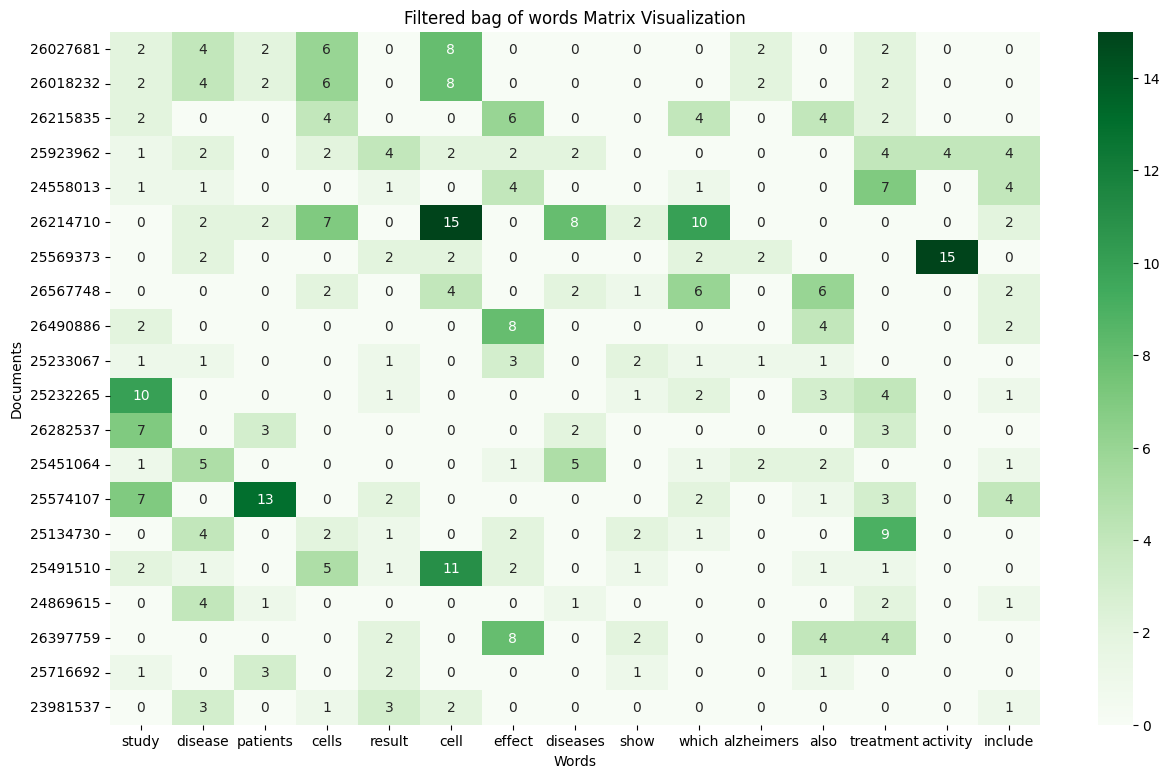

In [9]:
first_row = 0
last_row = 20
first_column = 0
last_column = 15
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered bag of words', \
                                           filtered_bow_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], \
                                           filtered_word_list[first_column:last_column], as_int = True)

Generate tf-idf matrix from the list of preprocessed documents.

In [10]:
# TF-IDF representation
word_list, tfidf_matrix = LBD_03_feature_extraction.create_tfidf(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all ngrams: ', len(word_list))
# print(word_list)
# print(tfidf_matrix)

# Rearange (filter) the tfidf matrix according to the previously computed order from bow matrix.
tmp_filtered_word_list, tmp_filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, tfidf_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
tfidf_matrix = tmp_filtered_tfidf_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent ngrams: ', len(word_list))

Number of terms in initial vocabulary with all ngrams:  67451
Number of terms in preprocessed vocabulary after removing infrequent ngrams:  13694


Compute margins for tf-idf matrix.

In [11]:
sum_word_tfidf = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, tfidf_matrix)
max_word_tfidf = LBD_03_feature_extraction.max_tfidf_each_word_in_all_documents(word_list, tfidf_matrix)

sum_doc_tfidf = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, tfidf_matrix)
max_doc_tfidf = LBD_03_feature_extraction.max_tfidf_all_words_in_each_document(ids_list, tfidf_matrix)

print('Sum of tfidf for each word: ', dict(itertools.islice(sum_word_tfidf.items(), 7)))
print('Max of tfidf for each word: ', dict(itertools.islice(max_word_tfidf.items(), 7)))

print('Sum of tfidf for each document: ', dict(itertools.islice(sum_doc_tfidf.items(), 7)))
print('Max of tfidf for each document: ', dict(itertools.islice(max_doc_tfidf.items(), 7)))

# Compute the order of rows (documents) and columns (words) in the tfidf matrix so that the most important words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_doc_tfidf, reverse=True), ids_list) 

# Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, tfidf_matrix, filter_rows, filter_columns)

Sum of tfidf for each word:  {'0000the': 0.03433093136121786, '0001multivariate': 0.058015703439959106, '009015mugml': 0.05205087866857665, '01mgml': 0.08778170973655833, '023x105': 0.04723364503819353, '05mg': 0.05604770775789075, '08500001mum': 0.07974856427881118}
Max of tfidf for each word:  {'0000the': 0.03433093136121786, '0001multivariate': 0.058015703439959106, '009015mugml': 0.05205087866857665, '01mgml': 0.08778170973655833, '023x105': 0.04723364503819353, '05mg': 0.05604770775789075, '08500001mum': 0.07974856427881118}
Sum of tfidf for each document:  {'26579427': 6.09192889523364, '26567748': 8.325276415141488, '26560688': 5.991018701879066, '26560048': 6.309588756449263, '26559414': 4.858238642680788, '26548612': 4.376196260403611, '26531265': 7.216538517471006}
Max of tfidf for each document:  {'26579427': 0.25790698242200744, '26567748': 0.15682444884198368, '26560688': 0.26970826171180456, '26560048': 0.3790643824944051, '26559414': 0.2013377161904169, '26548612': 0.295

Visualize tf-idf matrix.

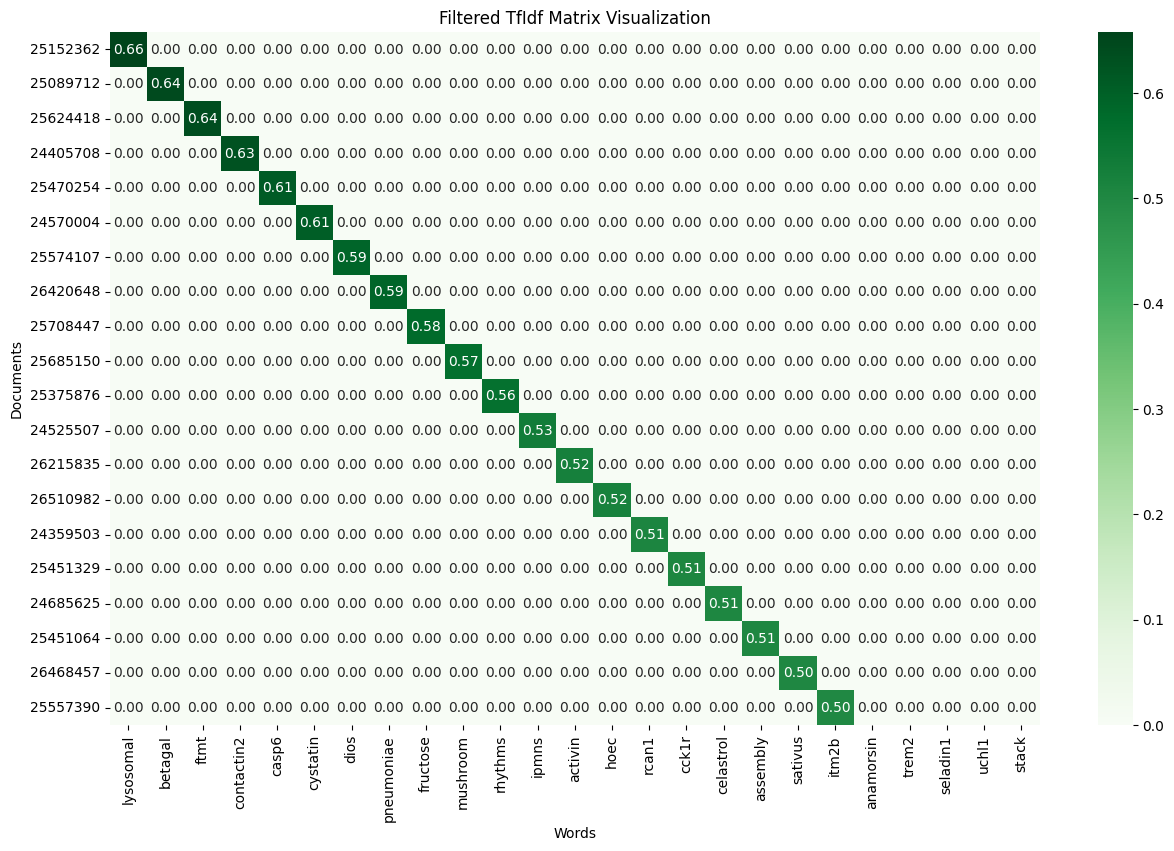

In [12]:
first_row = 0
last_row = 20
first_column = 0
last_column = 25
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered TfIdf', filtered_tfidf_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], filtered_word_list[first_column:last_column], as_int = False)

Generate a list of the domain names of all the documents and a list of unique domain names.

In [13]:
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(prep_docs_dict)
print('Domain names for the first few documents: ', domains_list[:7])
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
print('A list of all uniques domain names in all the documents: ', unique_domains_list)

Domain names for the first few documents:  ['Alzheimer', 'Alzheimer', 'Alzheimer', 'Alzheimer', 'Alzheimer', 'Alzheimer', 'Alzheimer']
A list of all uniques domain names in all the documents:  ['Alzheimer', 'GIMB']


In [14]:
# Generate domains_bow_matrix from bow_matrix using domain_names list to add bow_matrix rows for each unique domain name into a single row
domains_bow_matrix = np.empty((0, bow_matrix.shape[1]))
no_documents_in_domain = {}
for i, domain_name in enumerate(unique_domains_list):
    domain_docs_indices = [i for i, label in enumerate(domains_list) if label == domain_name]
    no_documents_in_domain[domain_name] = len(domain_docs_indices)
    print(domain_docs_indices[:7])
    tmp = (bow_matrix[domain_docs_indices,:]).sum(axis=0)
    print(i, tmp)
    domains_bow_matrix = np.vstack((domains_bow_matrix, tmp))
    # Compute centroid for the current cluster
    #centroid_x = np.mean(pca_result[cluster_docs_indices, 0])
    #centroid_y = np.mean(pca_result[cluster_docs_indices, 1])
print(domains_bow_matrix)
print(no_documents_in_domain)

[0, 1, 2, 3, 4, 5, 6]
0 [0 0 1 ... 1 5 1]
[430, 431, 432, 433, 434, 435, 436]
1 [1 1 0 ... 0 0 0]
[[0. 0. 1. ... 1. 5. 1.]
 [1. 1. 0. ... 0. 0. 0.]]
{'Alzheimer': 430, 'GIMB': 152}


In [15]:
def cell_value_in_bow_matrix(bow_matrix, domain_name, word):
    """
    """
    line_idx = unique_domains_list.index(domain_name)
    column_idx = word_list.index(word)
    return(bow_matrix[line_idx, column_idx])

cell_value_in_bow_matrix(domains_bow_matrix, unique_domains_list[0], word_list[0])


0.0

In [16]:
print("Dictionary of words, count and max(tfidf):")

max_word_tfidf_selected = {}
sum_word_tfidf_selected = {} ### TODO from her on ...
for word in max_word_tfidf.keys():
    if sum_count_docs_containing_word[word] >= 1:
        passed = True
        for domain_name in unique_domains_list:
            if cell_value_in_bow_matrix(domains_bow_matrix, domain_name, word) <= 0:
                passed = False
        if passed:
            max_word_tfidf_selected[word] = max_word_tfidf[word]
         
import itertools
print('All the words in vocabulary: ', len(max_word_tfidf))
print('Selected bterm candidate words: ', len(max_word_tfidf_selected), ' ', dict(itertools.islice(max_word_tfidf_selected.items(), 30)))

max_word_tfidf_selected_sorted = LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf_selected, True)

print('Sorted bterm candidate words: ', len(max_word_tfidf_selected_sorted), ' ', dict(itertools.islice(max_word_tfidf_selected_sorted.items(), 30)))
print('First and last sorted bterm word: ', list(max_word_tfidf_selected_sorted.items())[0], ' ', list(max_word_tfidf_selected_sorted.items())[-1])
print('Mean value of max tfidf values: ', np.array(list(max_word_tfidf_selected_sorted.values())).mean())

Dictionary of words, count and max(tfidf):
All the words in vocabulary:  13694
Selected bterm candidate words:  3186   {'10day': 0.05155405678898795, '1980s': 0.06598911667836896, '22nd': 0.055287595799117975, '5year': 0.09286001505162042, 'abilities': 0.12341278199221857, 'ability': 0.11397969567330787, 'ablation': 0.0870271959113037, 'able': 0.08739089018472009, 'able modify': 0.08985570518374227, 'abnormal': 0.18601909370982872, 'abnormalities': 0.09864460286451107, 'absence': 0.060435516505127324, 'absent': 0.05938699743906345, 'absolute': 0.06931466180555733, 'absorption': 0.10419111675998022, 'abundance': 0.08708381758858319, 'abundant': 0.06936307400140976, 'academic': 0.07342689810357306, 'access': 0.08601130103752648, 'accommodate': 0.07814603692273957, 'accompany': 0.09856934180863604, 'accord': 0.12658576695351212, 'account': 0.05783315953786421, 'accumulation': 0.1257836294852093, 'accuracy': 0.18481201573486816, 'accurate': 0.04991315830995517, 'accurately': 0.056880500377

In [17]:
bterms_list = list(max_word_tfidf_selected_sorted.keys())
bterms_list_length = len(bterms_list)

df = pd.DataFrame({'b-term': bterms_list, 'max TF-IDF': list(max_word_tfidf_selected_sorted.values())})
df[0:25]

,b-term,max tfidf
0,pneumoniae,0.588468
1,bioenergetic,0.473890
2,soybean,0.462953
3,chloride,0.460121
4,bile,0.457822
5,exercise,0.455394
6,scan,0.448019
7,sepsis,0.443924
8,eradication,0.417441
9,test,0.412516


In [22]:
df[1201:1225]

,b-term,max tfidf
1201,microscope,0.105286
1202,taoc,0.105286
1203,investigation,0.105211
1204,detect,0.105206
1205,coordinate,0.105163
1206,robust,0.105163
1207,recognition,0.105061
1208,technologies,0.105019
1209,density,0.104918
1210,travel,0.104917


In [18]:
print(max_word_tfidf_selected)

{'10day': 0.05155405678898795, '1980s': 0.06598911667836896, '22nd': 0.055287595799117975, '5year': 0.09286001505162042, 'abilities': 0.12341278199221857, 'ability': 0.11397969567330787, 'ablation': 0.0870271959113037, 'able': 0.08739089018472009, 'able modify': 0.08985570518374227, 'abnormal': 0.18601909370982872, 'abnormalities': 0.09864460286451107, 'absence': 0.060435516505127324, 'absent': 0.05938699743906345, 'absolute': 0.06931466180555733, 'absorption': 0.10419111675998022, 'abundance': 0.08708381758858319, 'abundant': 0.06936307400140976, 'academic': 0.07342689810357306, 'access': 0.08601130103752648, 'accommodate': 0.07814603692273957, 'accompany': 0.09856934180863604, 'accord': 0.12658576695351212, 'account': 0.05783315953786421, 'accumulation': 0.1257836294852093, 'accuracy': 0.18481201573486816, 'accurate': 0.04991315830995517, 'accurately': 0.056880500377534615, 'acetylcholinesterase': 0.15315187420634277, 'acetylcholinesterase ache': 0.0676884362106841, 'ache': 0.2910704

In [19]:
name = 'nitric'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

nitric: position in the list of rare terms 1216 (3186), max tfidf: 0.105


In [20]:
name = 'nitric oxide'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

nitric oxide: position in the list of rare terms 1217 (3186), max tfidf: 0.105


In [ ]:
petric_bterms = ["22q112", "deletion syndrome", "asbestos", "bcl2", "bombesin", "calmodulin", "radiation", \
                 "hypothyroxinemia", "synaptic", "synaptic plasticity", "type 1 diabetes", \
                 "ulcerative colitis", "working memory", \
                 "t17p22q21"]

petric_bterms = ["22q112", "deletion", "syndrome", "asbestos", "bcl2", "bombesin", "calmodulin", "radiation", \
                 "hypothyroxinemia", "synaptic", "plasticity", "diabetes", \
                 "colitis", "work", "memory", "t17p22q21"]
nn = 0
indb = []
size = len(max_word_tfidf_selected_sorted)
for name in petric_bterms:
    if name in max_word_tfidf_selected_sorted.keys():
       nn += 1
       position = list(max_word_tfidf_selected_sorted.keys()).index(name)
       indb.append(position)
       print(name, ': ', 'position in the list of potential bterms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
             '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), ' part: ', format(position/size*100, '.1f'), sep='')
    else:
        print('NOT:', name, 'NOT in the list.')   
print(nn, len(petric_bterms))
print(indb)

Missing and changed b-terms:

- maternal hypothyroxinemia -> hypothyroxinemia
- ulcerative colitis -> colitis
- t17p22q21 - found only in Autism documents

TODO: implement selected heuristics for bterm ranking

In [ ]:
pt = []
for i in range(size):
    pt.append(0)
for i in range(len(indb)):
    for j in range(indb[i], size):
        pt[j] += 1
print(pt)
suma = 0
part = 0
for i in range(size):
    print((i+1)/size*100.0, pt[i]/len(indb)*100.0)
    part += pt[i]
    suma += len(indb)
print(part/suma*100.0)

no_all_bterm_candidates = size
no_swansons_bterms = len(indb)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example ROC curve points (y-values), replace with the actual list of 120 numbers
roc_points = pt

# X-values for the ROC curve (0 to 120)
x_values = np.arange(0, no_all_bterm_candidates)

# Calculating the AUC for the given ROC curve using the trapezoidal rule
auc = np.trapz(roc_points, x_values) / (no_all_bterm_candidates*no_swansons_bterms) * 100  # Normalizing by the area of the full plot

# Plotting the default curve (50% AUC)
default_x = np.array([0, no_all_bterm_candidates])
default_y = np.array([0, no_swansons_bterms])
plt.plot(default_x, default_y, label='Default Curve (50% AUC)', linestyle='--', color='gray')

# Plotting the given ROC curve
plt.plot(x_values, roc_points, label=f'Given ROC Curve (AUC: {auc:.2f})', color='blue')

# Adding labels and legend
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate (Discrete)')
plt.ylabel('True Positive Rate (Discrete)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()